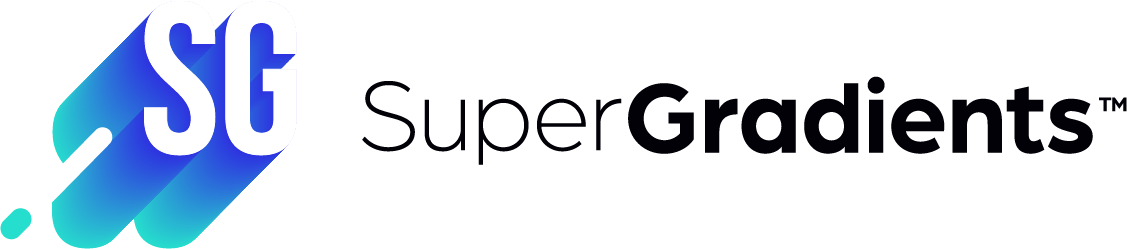

# Transfer Learning / Fine tuning with SuperGradients

In the following tutorial, we will demonstrate how to use SuperGradients to perform transfer learning for object detection. In our scenario, we will try to transfer-learn from our COCO-pretrained YoloV5nano, to a sub-dataset of Pascal VOC that includes the "person" class only.

In order to do so we will:


*   Generate new anchors that are a better fit to our new dataset.
*   Load our pretrained YoloV5nano, replace it's anchors and it's detect layers according to the new number of classes (single class)


*   Define training parameters.
*   Start training!





First, let's install the latest version of super-gradients:

In [1]:
#! pip install https://deci-pretrained-models.s3.amazonaws.com/super_gradients-1.5.0rc2428-py3-none-any.whl gwpy &> /dev/null
! pip install super-gradients==1.5.0
! pip install matplotlib==3.1.3

     |████████████████████████████████| 497 kB 5.4 MB/s 
     |████████████████████████████████| 242 kB 48.6 MB/s 
     |████████████████████████████████| 4.9 MB 31.1 MB/s 
     |████████████████████████████████| 145 kB 40.7 MB/s 
     |████████████████████████████████| 396 kB 47.1 MB/s 
     |████████████████████████████████| 47 kB 3.4 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 2.9 MB 38.3 MB/s 
     |████████████████████████████████| 2.8 MB 45.7 MB/s 
     |████████████████████████████████| 11.2 MB 47.3 MB/s 
     |████████████████████████████████| 74 kB 835 kB/s 
     |████████████████████████████████| 280 kB 50.1 MB/s 
     |████████████████████████████████| 131 kB 54.8 MB/s 
     |████████████████████████████████| 60.4 MB 29 kB/s 
     |████████████████████████████████| 12.7 MB 28.3 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 79 kB 6.9 MB/s 
     |████████████████

     |████████████████████████████████| 13.1 MB 4.7 MB/s            
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
super-gradients 1.5.0 requires matplotlib>=3.3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Imports:

In [2]:
import super_gradients
from super_gradients.training import SgModel, MultiGPUMode
from super_gradients.training.datasets.dataset_interfaces.dataset_interface import \
    PascalVOCUnifiedDetectionDataSetInterface
from super_gradients.training.models.detection_models.yolov5 import YoloV5PostPredictionCallback
from super_gradients.training.utils.detection_utils import base_detection_collate_fn
from super_gradients.training.metrics import DetectionMetrics
from super_gradients.training.utils.detection_utils import Anchors
from super_gradients.training.utils.detection_utils import AnchorGenerator
import os
super_gradients.init_trainer()

You did not mention an AWS environment.You can set the environment variable ENVIRONMENT_NAME with one of the values: development,staging,production
callbacks -WARNING- Failed to import deci_lab_client


# Generating new anchors

Since our model has been trained with anchors that were a good fit for the 80 classes from COCO dataset, its likely that we can find a better fit for our single class, which intutively has typical bounding boxes for it.
(If you are not familiar with the concept of anchor boxes, for more information see https://blog.roboflow.com/what-is-an-anchor-box/).


Let's start with downloading the data and intializing a dataset interface that we will use for the anchor generation (note that we just need to instantiate PascalVOCUnifiedDetectionDataSetInterface with parameter "download": True, for the dataset to be downloaded):

In [3]:
dataset_params_anchors = {"batch_size": 1,
                          "val_batch_size": 1,
                          "train_image_size": 512,
                          "val_image_size": 512,
                          "train_sample_loading_method": "default",
                          "class_inclusion_list": ['person'],
                          "download": True,
                          "data_root": "/home/data/pascal_unified_coco_format/"
                          }
dataset_interface = PascalVOCUnifiedDetectionDataSetInterface(dataset_params=dataset_params_anchors, cache_labels=True)

  0%|          | 0.00/425M [00:00<?, ?B/s]

Unzipping /home/data/pascal_unified_coco_format/images/VOCtrainval_06-Nov-2007.zip...


  0%|          | 0.00/418M [00:00<?, ?B/s]

Unzipping /home/data/pascal_unified_coco_format/images/VOCtest_06-Nov-2007.zip...


  0%|          | 0.00/1.82G [00:00<?, ?B/s]

Unzipping /home/data/pascal_unified_coco_format/images/VOCtrainval_11-May-2012.zip...


test2007: 100%|██████████| 4952/4952 [00:02<00:00, 1950.15it/s]
Caching labels (1025 found, 1471 missing, 0 duplicate, for 2501 images): 100%|██████████| 2501/2501 [00:00<00:00, 8160.90it/s]
Caching labels (1994 found, 3723 missing, 0 duplicate, for 5717 images): 100%|██████████| 5717/5717 [00:00<00:00, 7989.04it/s]
Caching labels (983 found, 1527 missing, 0 duplicate, for 2510 images): 100%|██████████| 2510/2510 [00:00<00:00, 7197.56it/s]
Caching labels (2093 found, 3729 missing, 0 duplicate, for 5823 images): 100%|██████████| 5823/5823 [00:00<00:00, 8227.16it/s]


[Errno 2] No such file or directory: '/home/data/pascal_unified_coco_format/images/VOCdevkit/VOC2007/ImageSets/Main/test.shapes'


Reading image shapes: 100%|██████████| 4952/4952 [00:00<00:00, 7090.52it/s]
Caching labels (2007 found, 2945 missing, 0 duplicate, for 4952 images): 100%|██████████| 4952/4952 [00:00<00:00, 7874.91it/s]


Moving on to generating the anchors: we run K-means in order to cluster the bounding boxes of our training set  (clusters are plotted in the output cell below).

Reading image shapes: 100%|██████████| 6095/6095 [00:00<00:00, 6193.53it/s]

detection_utils -INFO- Running kmeans for 9 anchors on 13256 points...


detection_utils -INFO- Initial results
detection_utils -INFO- thr=0.34: 0.9940 best possible recall, 4.93 anchors past thr
detection_utils -INFO- num_anchors=9, img_size=512
detection_utils -INFO-  metric_all=0.404/0.770-mean/best, past_thr=0.578-mean: 
29,51,  54,105,  95,157,  99,244,  184,219,  158,338,  271,296,  280,440,  428,338


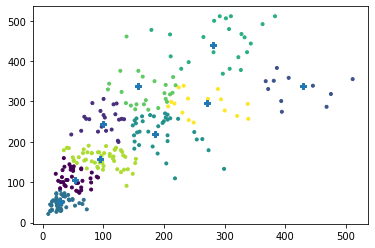

Anchors Generator: Evolving anchors with Genetic Algorithm: fitness = 0.7860: 100%|██████████| 1000/1000 [00:05<00:00, 189.58it/s]

detection_utils -INFO- Final results
detection_utils -INFO- thr=0.34: 0.9986 best possible recall, 4.84 anchors past thr
detection_utils -INFO- num_anchors=9, img_size=512
detection_utils -INFO-  metric_all=0.401/0.786-mean/best, past_thr=0.578-mean: 


21,45,  32,80,  61,102,  69,190,  116,162,  123,270,  207,256,  239,350,  397,361


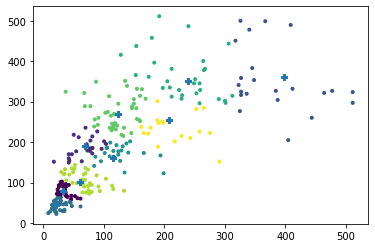

In [4]:
anch_gen = AnchorGenerator()
anchors = anch_gen(dataset=dataset_interface.trainset, thresh=1/2.91)
anchors = Anchors(anchors_list=anchors,
                  strides=[8, 16, 32])

# Defining dataset parameters for training

Now that we are done with generating new anchors, let's change our dataset parameters to incorprate augmentations, change the batch size and use mosaic sampling method:

In [5]:
dataset_params = {"batch_size": 48,
                  "val_batch_size": 48,
                  "train_image_size": 512,
                  "val_image_size": 512,
                  "val_collate_fn": base_detection_collate_fn,
                  "train_collate_fn": base_detection_collate_fn,
                  "train_sample_loading_method": "mosaic",
                  "val_sample_loading_method": "default",
                  "dataset_hyper_param": {
                      "hsv_h": 0.015,  # IMAGE HSV-Hue AUGMENTATION (fraction)
                      "hsv_s": 0.7,  # IMAGE HSV-Saturation AUGMENTATION (fraction)
                      "hsv_v": 0.4,  # IMAGE HSV-Value AUGMENTATION (fraction)
                      "degrees": 0.0,  # IMAGE ROTATION (+/- deg)
                      "translate": 0.1,  # IMAGE TRANSLATION (+/- fraction)
                      "scale": 0.5,  # IMAGE SCALE (+/- gain)
                      "shear": 0.0},  # IMAGE SHEAR (+/- deg)
                  "class_inclusion_list": ['person'],
                  "download": False,
                  "data_root": "/home/data/pascal_unified_coco_format/"
                  }


Initialize an SgModel instance, and a Pascal VOC dataset interface:

In [6]:
trainer = SgModel(experiment_name="yolov5n_pascal_finetune", ckpt_root_dir="/home/data/notebook_ckpts/")
dataset_interface = PascalVOCUnifiedDetectionDataSetInterface(dataset_params=dataset_params, cache_labels=True)

Caching labels (1025 found, 1471 missing, 0 duplicate, for 2501 images): 100%|██████████| 2501/2501 [00:00<00:00, 8944.35it/s]
Caching labels (1994 found, 3723 missing, 0 duplicate, for 5717 images): 100%|██████████| 5717/5717 [00:00<00:00, 8377.10it/s]
Caching labels (983 found, 1527 missing, 0 duplicate, for 2510 images): 100%|██████████| 2510/2510 [00:00<00:00, 8817.56it/s]
Caching labels (2093 found, 3729 missing, 0 duplicate, for 5823 images): 100%|██████████| 5823/5823 [00:00<00:00, 8085.57it/s]
Caching labels (2007 found, 2945 missing, 0 duplicate, for 4952 images): 100%|██████████| 4952/4952 [00:00<00:00, 8511.17it/s]


Connecting the dataset interface will set SgModel's classes attribute according to Pascal VOC.

In [7]:
trainer.connect_dataset_interface(dataset_interface, data_loader_num_workers=2)

# Preparing our network for training

This is where the magic happens- since SgModels classes atrr was set to be different from coco's, after loading the pretrained YoloV5 nano, it will call it's replace_head method and change it's Detect layer accordingly. Notice we are also passing our newly generated anchors through 'arch_params'.



In [8]:
trainer.build_model(architecture="yolo_v5n", arch_params={"pretrained_weights": "coco", "anchors": anchors})

Downloading: "https://deci-pretrained-models.s3.amazonaws.com/YOLOv5+n/ckpt_best.pth" to /root/.cache/torch/hub/checkpoints/YOLOv5+n_ckpt_best.pth


  0%|          | 0.00/21.8M [00:00<?, ?B/s]

# Defining training parameters


In [9]:
# DEFINE TRAINING PARAMS. SEE DOCS FOR THE FULL LIST.
training_params = {"max_epochs": 50,
                   "lr_mode": "cosine",
                   "initial_lr": 0.0032,
                   "cosine_final_lr_ratio": 0.12,
                   "lr_warmup_epochs": 2,
                   "warmup_bias_lr": 0.05,  # LR TO START FROM DURING WARMUP (DROPS DOWN DURING WARMUP EPOCHS) FOR BIAS.
                   "loss": "yolo_v5_loss",
                   "criterion_params": {"anchors": anchors,
                                        "box_loss_gain": 0.0296, # COEF FOR BOX LOSS COMPONENT
                                        "cls_loss_gain": 0, # COEF FOR CLASSIFICATION
                                        "obj_loss_gain": 0.19264, # OBJECT BCE COEF
                                        "obj_pos_weight": 0.911,  # OBJECT BCE POSITIVE CLASS WEIGHT
                                        "anchor_threshold": 2.91  # RATIO DEFINING THE SIZE RANGE OF AN ANCHOR.
                                        },
                   "optimizer": "SGD",
                   "warmup_momentum": 0.5,
                   "optimizer_params": {"momentum": 0.9,
                                        "weight_decay": 0.0001,
                                        "nesterov": True},
                   "ema": True,
                   "train_metrics_list": [],
                   "valid_metrics_list": [DetectionMetrics(post_prediction_callback=YoloV5PostPredictionCallback(),
                                                           num_cls=len(
                                                               dataset_interface.classes))],
                   "loss_logging_items_names": ["GIoU", "obj", "cls", "Loss"],
                   "metric_to_watch": "mAP@0.50:0.95",
                   "greater_metric_to_watch_is_better": True,
                   "warmup_mode": "yolov5_warmup"}


Finally, call train!

In [ ]:
trainer.train(training_params=training_params)

sg_model -INFO- Using EMA with params {}
sg_model -INFO- Started training for 50 epochs (0/49)



Train epoch 0:   0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
Train epoch 0:  30%|██▉       | 38/127 [01:11<02:36,  1.76s/it, GIoU=2.39, Loss=0.0801, cls=0, gpu_mem=5.41, obj=0.0484]